In [15]:
import pandas as pd
import sqlalchemy

# Paramètres de connexion à la base de données SQL Server
server = 'DESKTOP-NTA9A3K'  # Remplace par le vrai nom de ton serveur
database = 'DW_PI7'  # Remplace par le nom de ta base de données
driver = 'ODBC Driver 17 for SQL Server'  # Assure-toi que ce driver est installé

# Création de l'engine SQLAlchemy pour se connecter à la base de données
engine = sqlalchemy.create_engine(f"mssql+pyodbc://{server}/{database}?trusted_connection=yes&driver={driver}")

# Vérifier la connexion et charger les données
with engine.connect() as conn:
    # Charger la table de faits
    query_facts = "SELECT * FROM fact_date2"
    fact_date2 = pd.read_sql(query_facts, conn)

    # Charger les tables de dimensions
    query_dim_bac = "SELECT * FROM Dim_Bac"
    query_dim_candidat = "SELECT * FROM Dim_Candidat"
    query_dim_gouvernorat = "SELECT * FROM Dim_Gouvernorat"
    query_dim_pays = "SELECT * FROM Dim_Payss"
    query_dim_dossiers = "SELECT * FROM Dim_Dossiers"
    query_dim_diplome = "SELECT * FROM Dim_Diplome"
    query_dim_concour = "SELECT * FROM Dim_Concour"
    query_dim_date = "SELECT * FROM Dim_date"

    dim_bac = pd.read_sql(query_dim_bac, conn)
    dim_candidat = pd.read_sql(query_dim_candidat, conn)
    dim_gouvernorat = pd.read_sql(query_dim_gouvernorat, conn)
    dim_pays = pd.read_sql(query_dim_pays, conn)
    dim_dossiers = pd.read_sql(query_dim_dossiers, conn)
    dim_diplome= pd.read_sql(query_dim_diplome, conn)
    dim_concour = pd.read_sql(query_dim_concour, conn)
    dim_date = pd.read_sql(query_dim_date, conn)





# Vérification des données fusionnées
print(fact_date2.head())

   Candidature_Pk  Dossier_Pk  Candidat_pk  Gouv_PK  Pays_Pk  Diplome_Pk  \
0             113        1773          113       17       32           0   
1             125        1936          125        7       32           0   
2             169         169          169       13       32           0   
3             258         258          258       10       32           0   
4             302         302          302       16       32           0   

   Concours_Pk  Bac_Pk  Date_Pk1  Date_Pk2  Date_Pk3  Date_Pk4  Date_Pk5  \
0           39       2  20220724  20230808  20230811  20230815  20220812   
1           41       3  20220722  20210814  20210801  20210805  20220726   
2           43       1  20220721  20210806  20210811  20210815  20220706   
3           37       6  20220717  20220811  20230801  20230805  20220709   
4           43      10  20220717  20210806  20210811  20210815  20220806   

   score_final  moy_bac_et  Admission  
0        95.35       14.50          0  
1     

In [17]:
print("Colonnes de fact_date2 :", fact_date2.columns.tolist())
print("Colonnes de dim_gouvernorat :", dim_gouvernorat.columns.tolist())
print("Colonnes de dim_bac :", dim_bac.columns.tolist())

Colonnes de fact_date2 : ['Candidature_Pk', 'Dossier_Pk', 'Candidat_pk', 'Gouv_PK', 'Pays_Pk', 'Diplome_Pk', 'Concours_Pk', 'Bac_Pk', 'Date_Pk1', 'Date_Pk2', 'Date_Pk3', 'Date_Pk4', 'Date_Pk5', 'score_final', 'moy_bac_et', 'Admission']
Colonnes de dim_gouvernorat : ['Gouv_PK', 'code_gouv', 'gouvernorat']
Colonnes de dim_bac : ['Bac_Pk', 'nature_bac', 'bac']


In [19]:
# Jointure 1 : fact_date2 + dim_gouvernorat
df = pd.merge(
    left=fact_date2,
    right=dim_gouvernorat,
    left_on='Gouv_PK',
    right_on='Gouv_PK',
    how='left'
)

# Jointure 2 : Ajout de dim_bac
df = pd.merge(
    left=df,
    right=dim_bac,
    left_on='Bac_Pk',
    right_on='Bac_Pk',
    how='left'
)

In [21]:
print("Colonnes après fusion :", df.columns.tolist())
assert {'gouvernorat', 'score_final', 'moy_bac_et', 'Admission', 'nature_bac'}.issubset(df.columns)

Colonnes après fusion : ['Candidature_Pk', 'Dossier_Pk', 'Candidat_pk', 'Gouv_PK', 'Pays_Pk', 'Diplome_Pk', 'Concours_Pk', 'Bac_Pk', 'Date_Pk1', 'Date_Pk2', 'Date_Pk3', 'Date_Pk4', 'Date_Pk5', 'score_final', 'moy_bac_et', 'Admission', 'code_gouv', 'gouvernorat', 'nature_bac', 'bac']


In [23]:
gov_stats = df.groupby('gouvernorat').agg({
    'score_final': 'mean',
    'moy_bac_et': 'mean',
    'Admission': lambda x: (x == 1).mean(),
    'Dossier_Pk': 'count',
    'nature_bac': lambda x: x.mode()[0] if not x.empty else None
}).rename(columns={
    'Dossier_Pk': 'nb_candidats',
    'Admission': 'taux_admission'
})

In [25]:
gov_stats = gov_stats.dropna()
print(gov_stats.head())

             score_final  moy_bac_et  taux_admission  nb_candidats nature_bac
gouvernorat                                                                  
Ariana         45.839444   13.528333        0.222222            54      SCEXP
Ben Arous      58.160750   13.614000        0.300000            40      SPORT
Bizerte        58.039706   13.717353        0.323529            34       MATH
Béja           47.268889   13.160278        0.388889            36      SPORT
Gabès          50.081351   13.462432        0.297297            37      SPORT


In [27]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
gov_stats['bac_encoded'] = le.fit_transform(gov_stats['nature_bac'])

In [29]:
from sklearn.preprocessing import StandardScaler
features = ['score_final', 'moy_bac_et', 'taux_admission', 'nb_candidats', 'bac_encoded']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(gov_stats[features])

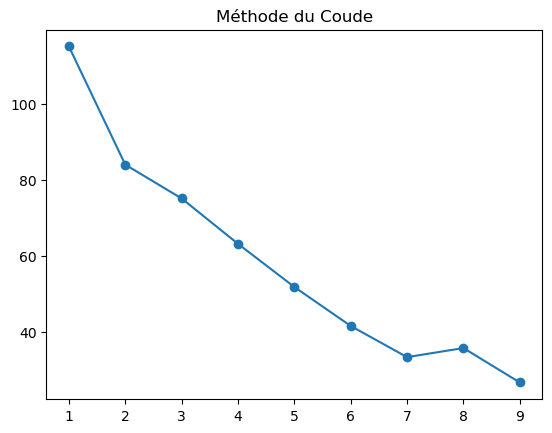

In [31]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
inerties = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inerties.append(kmeans.inertia_)

plt.plot(range(1, 10), inerties, marker='o')
plt.title('Méthode du Coude')
plt.show()

In [33]:
kmeans = KMeans(n_clusters=3, random_state=42)
gov_stats['cluster'] = kmeans.fit_predict(X_scaled)

In [35]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
gov_stats[['PC1', 'PC2']] = pca.fit_transform(X_scaled)

C:\Users\user\AppData\Local\Temp\ipykernel_13020\2731238929.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  gov_stats['PC1'][line],
C:\Users\user\AppData\Local\Temp\ipykernel_13020\2731238929.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  gov_stats['PC2'][line],


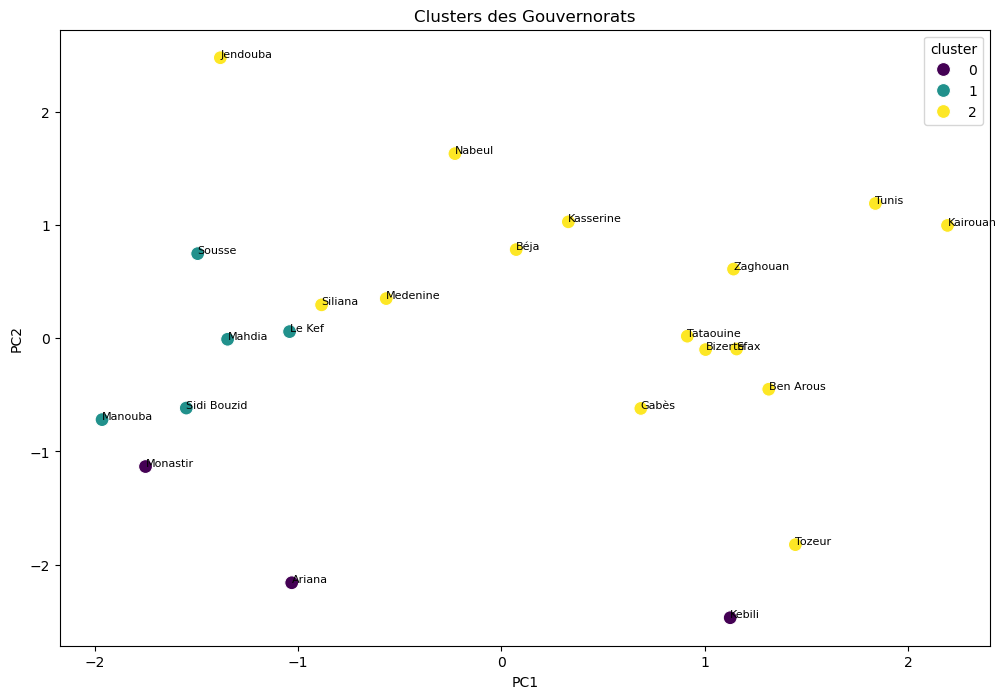

In [37]:
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(
    data=gov_stats,
    x='PC1', y='PC2',
    hue='cluster',
    palette='viridis',
    s=100
)

# Ajout des étiquettes
for line in range(gov_stats.shape[0]):
    plt.text(
        gov_stats['PC1'][line],
        gov_stats['PC2'][line],
        gov_stats.index[line],
        fontsize=8
    )

plt.title('Clusters des Gouvernorats')
plt.show()

In [29]:
# Exporter les données dans un fichier CSV
gov_stats.to_csv("gouvernorats_clusters.csv", index=True)


In [45]:
cluster_profile = gov_stats.groupby('cluster').agg({
    'score_final': ['mean', 'std'],
    'moy_bac_et': 'mean',
    'taux_admission': 'mean',
    'nb_candidats': 'sum',
    'nature_bac': lambda x: x.mode()[0]
})
print(cluster_profile)

        score_final           moy_bac_et taux_admission nb_candidats  \
               mean       std       mean           mean          sum   
cluster                                                                
0         48.646690  3.241756  13.537325       0.212691          148   
1         46.074903  2.532920  13.435280       0.346035          206   
2         55.292703  3.630688  13.296501       0.331087          593   

        nature_bac  
          <lambda>  
cluster             
0             ECOG  
1             INFO  
2            SPORT  


In [53]:
# Essayer DBSCAN pour détection automatique du nombre de clusters
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=3)
gov_stats['cluster'] = dbscan.fit_predict(X_scaled)

In [57]:
# Vérification des données avant DBSCAN
print("Dimensions des données :", X_scaled.shape)
print("Aperçu des données normalisées :\n", X_scaled[:3])

Dimensions des données : (23, 5)
Aperçu des données normalisées :
 [[-1.28982932  0.514019   -1.5984334   2.00277508  0.34998291]
 [ 1.12450247  0.77266206 -0.31239731 -0.18330484  0.85308335]
 [ 1.10078415  1.08470315  0.07665562 -1.12019623 -0.15311752]]


In [59]:
from sklearn.cluster import DBSCAN
import numpy as np

# Paramètres initiaux (à ajuster)
eps = 0.8  # Rayon de voisinage
min_samples = 3  # Nombre minimum de points pour former un cluster

dbscan = DBSCAN(eps=eps, min_samples=min_samples)

In [61]:
# Clustering
gov_stats['cluster_dbscan'] = dbscan.fit_predict(X_scaled)

# Analyse des résultats
labels = gov_stats['cluster_dbscan']
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

print(f"Nombre de clusters trouvés : {n_clusters}")
print(f"Points considérés comme bruit : {n_noise}")
print("Répartition des clusters :\n", gov_stats['cluster_dbscan'].value_counts())

Nombre de clusters trouvés : 1
Points considérés comme bruit : 23
Répartition des clusters :
 cluster_dbscan
-1    23
Name: count, dtype: int64
